In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import os
import numpy as np
import imgaug.augmenters as iaa
from PIL import Image

# Specify the path to your dataset
dataset_path = '/content/drive/MyDrive/data_corrected'
train_test_folders = ["train", "test"]

# Create an augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),        # horizontal flips
    iaa.Affine(rotate=(-30, 30)),  # random rotations
    iaa.GaussianBlur(sigma=(0, 1.0)),  # random gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.1 * 255))  # random noise
])

# Number of augmented images to generate per original image
augmentation_factor = 5

# Loop through each "train" and "test" subfolder
for train_test_folder in train_test_folders:
    class_folders = ["covid", "non"]

    # Loop through each class ("covid" and "non")
    for class_folder in class_folders:
        class_path = os.path.join(dataset_path, train_test_folder, class_folder)

        # If the class is "non," consider subfolders within it
        if class_folder == "non":
            subfolders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]

            # Loop through each subfolder within "non"
            for subfolder in subfolders:
                subfolder_path = os.path.join(class_path, subfolder)

                # List all image files in the subfolder
                image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

                # Loop through each image in the subfolder
                for image_file in image_files:
                    # Load the image
                    image_path = os.path.join(subfolder_path, image_file)
                    img = np.array(Image.open(image_path))

                    # Apply augmentation and save the augmented images in the same folder
                    for i in range(augmentation_factor):
                        augmented_img = seq.augment_image(img)
                        output_file = f"{os.path.splitext(image_file)[0]}_aug_{i}.jpg"
                        output_file_path = os.path.join(subfolder_path, output_file)
                        Image.fromarray(augmented_img).save(output_file_path)
        else:
            # For "covid" class, directly list all image files
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

            # Loop through each image in the class folder
            for image_file in image_files:
                # Load the image
                image_path = os.path.join(class_path, image_file)
                img = np.array(Image.open(image_path))

                # Apply augmentation and save the augmented images in the same folder
                for i in range(augmentation_factor):
                    augmented_img = seq.augment_image(img)
                    output_file = f"{os.path.splitext(image_file)[0]}_aug_{i}.jpg"
                    output_file_path = os.path.join(class_path, output_file)
                    Image.fromarray(augmented_img).save(output_file_path)


In [ ]:
# # Use the custom function in the transformations
transformations = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Lambda(lambda x: transforms.functional.adjust_gamma(x, gamma=0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.Lambda(lambda x: transforms.functional.adjust_sharpness(x, sharpness_factor=2.0))], p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Load the dataset
dataset = ImageFolder(root='/content/drive/MyDrive/data_corrected', transform=transformations)


In [ ]:
import os

# Specify the path to your dataset
dataset_path = '/content/drive/MyDrive/data_corrected'

# List of classes ("covid" and "non")
classes = ["covid", "non"]

# Loop through each class
for class_folder in classes:
    class_path = os.path.join(dataset_path, "train", class_folder)

    # Check if the class is "non" and list subfolders
    if class_folder == "non":
        subfolders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]

        # Loop through each subfolder within "non"
        for subfolder in subfolders:
            subfolder_path = os.path.join(class_path, subfolder)

            # List all image files in the subfolder
            image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

            # Print the number of samples in each subfolder
            print(f"Class {class_folder}, Subfolder {subfolder}: {len(image_files)} samples")
    else:
        # For "covid" class, directly list all image files
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Print the number of samples in the class
        print(f"Class {class_folder}: {len(image_files)} samples")

# Repeat the same process for the "test" subfolder
for class_folder in classes:
    class_path = os.path.join(dataset_path, "test", class_folder)

    # Check if the class is "non" and list subfolders
    if class_folder == "non":
        subfolders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]

        # Loop through each subfolder within "non"
        for subfolder in subfolders:
            subfolder_path = os.path.join(class_path, subfolder)

            # List all image files in the subfolder
            image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

            # Print the number of samples in each subfolder
            print(f"Class {class_folder}, Subfolder {subfolder}: {len(image_files)} samples")
    else:
        # For "covid" class, directly list all image files
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Print the number of samples in the class
        print(f"Class {class_folder}: {len(image_files)} samples")


Class covid: 504 samples
Class non, Subfolder Lung_Opacity: 714 samples
Class non, Subfolder No_Finding: 10200 samples
Class non, Subfolder Edema: 720 samples
Class non, Subfolder Enlarged_Cardiomediastinum: 690 samples
Class non, Subfolder Pleural_Other: 324 samples
Class non, Subfolder Pneumonia: 282 samples
Class non, Subfolder Pneumothorax: 678 samples
Class covid: 600 samples
Class non, Subfolder Support_Devices: 678 samples
Class non, Subfolder Fracture: 714 samples
Class non, Subfolder Lung_Lesion: 654 samples
Class non, Subfolder Cardiomegaly: 672 samples
Class non, Subfolder Atelectasis: 702 samples
Class non, Subfolder Consolidation: 672 samples


In [ ]:
# Split the dataset into 80% training and 20% testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [ ]:
# Apply 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the ViT model
feature_extractor = ViTFeatureExtractor(model_name="google/vit-base-patch16-224", do_lower_case=True)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(model.config.hidden_size, 2)

# Move model to GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


In [ ]:
# Training and evaluation
for fold, (train_index, val_index) in enumerate(skf.split(range(len(train_dataset)), [train_dataset[i][1] for i in range(len(train_dataset))])):
    train_fold, val_fold = random_split(train_dataset, [len(train_index), len(val_index)])

    # Class balance correction
    covid_indices = [i for i in range(len(train_fold)) if train_fold[i][1] == 0]
    non_covid_indices = [i for i in range(len(train_fold)) if train_fold[i][1] == 1]

    # Augment "non" class images
    non_covid_indices = shuffle(non_covid_indices, random_state=42)
    non_covid_indices = non_covid_indices[:len(covid_indices)]

    # Concatenate augmented "non" indices with "covid" indices
    train_indices = covid_indices + non_covid_indices

    # Shuffle the indices
    train_indices = shuffle(train_indices, random_state=42)

    # Create DataLoader for training and validation
    train_loader = DataLoader(torch.utils.data.Subset(train_fold, train_indices), batch_size=32, shuffle=True)
    val_loader = DataLoader(val_fold, batch_size=32, shuffle=False)

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        average_train_loss = running_loss / len(train_loader)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Fold {fold + 1}, Validation Accuracy: {accuracy:.4f}")


In [ ]:
# Test DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Testing
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8370


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       965
           1       0.89      0.90      0.89      3206

    accuracy                           0.84      4171
   macro avg       0.77      0.76      0.77      4171
weighted avg       0.83      0.84      0.84      4171

Confusion Matrix:


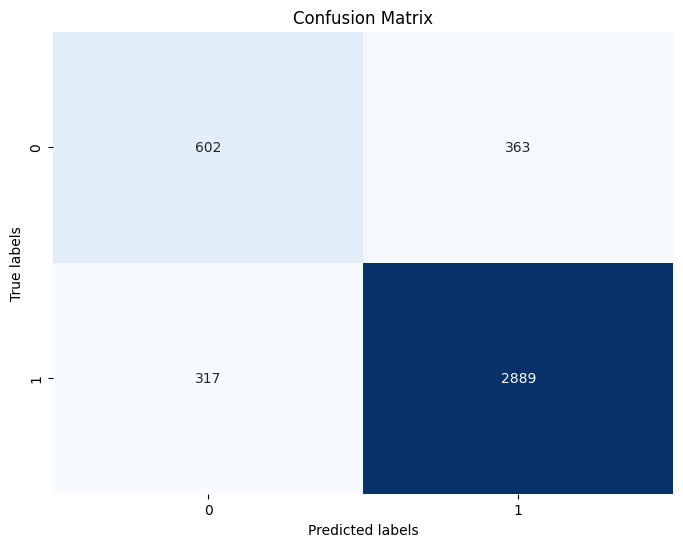

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'all_labels' are the true labels and 'all_preds' are the predicted labels from your test set
true_labels = all_labels
predicted_labels = all_preds

# Display classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Display confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
